https://myoptimizationnotes.blogspot.com/2024/02/project-management-western-hills.html 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the directed graph for the project activities
G = nx.DiGraph()

In [2]:
# Adding nodes with activity times as attributes
activities = {
    'A': {'description': 'Prepare architectural drawings', 'time': 5},
    'B': {'description': 'Identify potential new entrants', 'time': 6},
    'C': {'description': 'Develop prospectus for tenants', 'time': 4, 'predecessors': ['A']},
    'D': {'description': 'Select contractor', 'time': 3, 'predecessors': ['A']},
    'E': {'description': 'Prepare Building permits', 'time': 1, 'predecessors': ['A']},
    'F': {'description': 'Obtain approval for building permits', 'time': 4, 'predecessors': ['E']},
    'G': {'description': 'Perform Construction', 'time': 14, 'predecessors': ['D', 'F']},
    'H': {'description': 'Finalize contracts with tenants', 'time': 12, 'predecessors': ['B', 'C']},
    'I': {'description': 'Tenants move in', 'time': 2, 'predecessors': ['G', 'H']}
}

In [3]:
# Add nodes and edges to the graph
for activity, info in activities.items():
    G.add_node(activity, time=info['time'], description=info['description'])
    # Add edges from predecessors if they exist
    if 'predecessors' in info:
        for pred in info['predecessors']:
            G.add_edge(pred, activity)

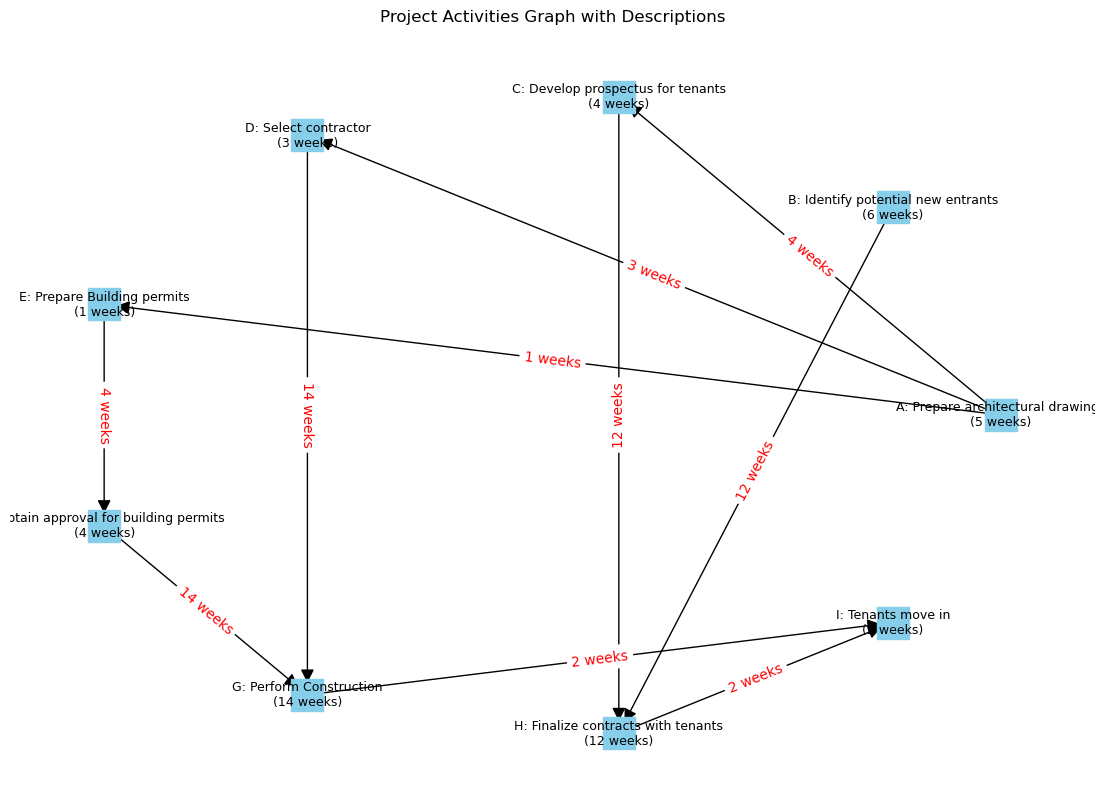

In [16]:
# Drawing the graph with rectangular nodes and including activity descriptions

plt.figure(figsize=(14, 10))

# Using the same positions for consistency but adjusting for readability
pos = nx.circular_layout(G)

# Draw the graph using rectangular nodes
nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, arrows=True,arrowsize=20)

# Labels with activity descriptions
labels = {node: f"{node}: {data['description']}\n({data['time']} weeks)" for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# Draw edge labels to show durations directly on the edges
edge_labels = {(u, v): f"{G.nodes[v]['time']} weeks" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_color='red')

plt.title('Project Activities Graph with Descriptions')
plt.axis('off')  # Turn off the axis
plt.show()


In [17]:
import pandas as pd

# Initialize ES and EF with 0 for start activities and max possible value for others
for node in G.nodes:
    G.nodes[node]['ES'] = 0 if not list(G.predecessors(node)) else float('inf')
    G.nodes[node]['EF'] = 0

# Calculate ES and EF
for node in nx.topological_sort(G):
    predecessors = list(G.predecessors(node))
    if predecessors:
        G.nodes[node]['ES'] = max(G.nodes[p]['EF'] for p in predecessors)
    G.nodes[node]['EF'] = G.nodes[node]['ES'] + G.nodes[node]['time']

# Initialize LF and LS with EF for end activities for backward pass
max_ef = max(G.nodes[node]['EF'] for node in G.nodes)
for node in G.nodes:
    G.nodes[node]['LF'] = max_ef
    G.nodes[node]['LS'] = float('inf')

# Calculate LF and LS
for node in reversed(list(nx.topological_sort(G))):
    successors = list(G.successors(node))
    if successors:
        G.nodes[node]['LF'] = min(G.nodes[s]['LS'] for s in successors)
    G.nodes[node]['LS'] = G.nodes[node]['LF'] - G.nodes[node]['time']

# Calculate Slack and identify Critical Path
for node in G.nodes:
    G.nodes[node]['Slack'] = G.nodes[node]['LS'] - G.nodes[node]['ES']
    G.nodes[node]['Critical Path?'] = "Yes" if G.nodes[node]['Slack'] == 0 else ""

# Create DataFrame
df_columns = ['ES', 'LS', 'EF', 'LF', 'Slack', 'Critical Path?']
df_data = {col: [G.nodes[node][col] for node in G.nodes] for col in df_columns}
df = pd.DataFrame(df_data, index=G.nodes)

df


,ES,LS,EF,LF,Slack,Critical Path?
A,0,0,5,5,0,Yes
B,0,6,6,12,6,
C,5,8,9,12,3,
D,5,7,8,10,2,
E,5,5,6,6,0,Yes
F,6,6,10,10,0,Yes
G,10,10,24,24,0,Yes
H,9,12,21,24,3,
I,24,24,26,26,0,Yes


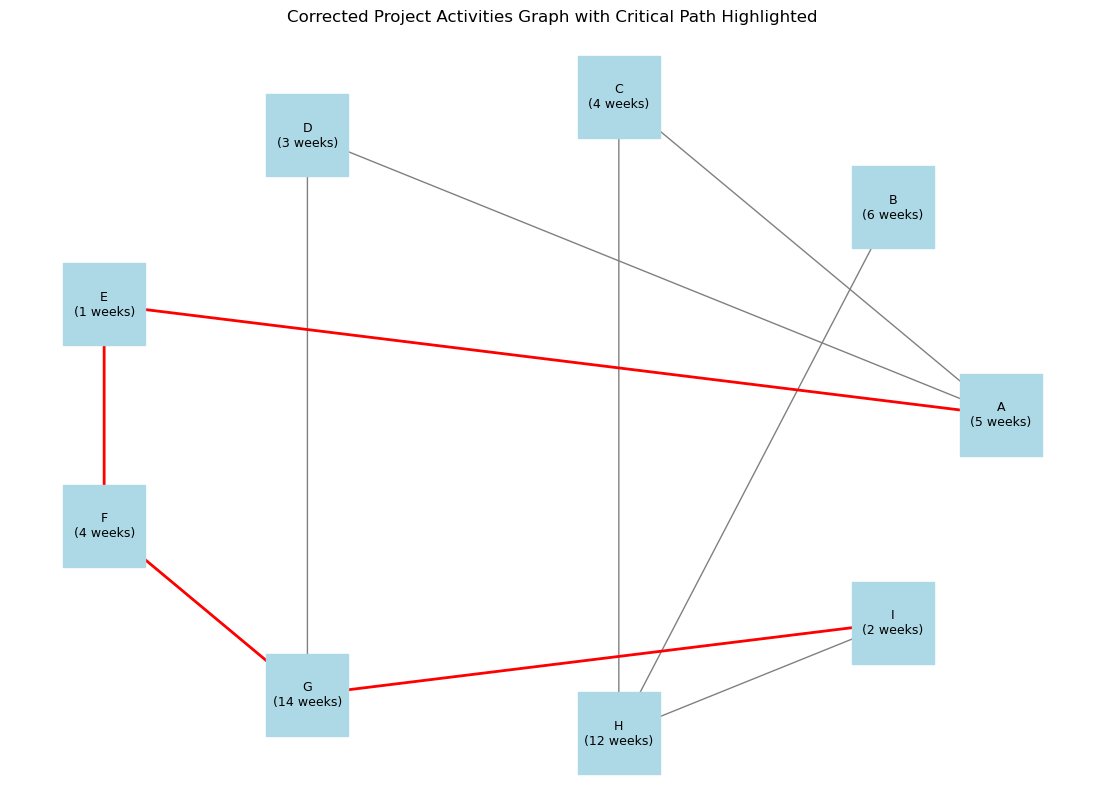

In [18]:
# Correcting the graph to ensure only the actual critical path edges are thicker and red
# We need to specifically identify edges that lead into nodes on the critical path where the predecessor is also on the critical path

# Recalculate critical path edges correctly considering both node and its predecessor must be on the critical path
actual_critical_path_edges = [(u, v) for u, v in G.edges if G.nodes[u]['Critical Path?'] == 'Yes' and G.nodes[v]['Critical Path?'] == 'Yes']

plt.figure(figsize=(14, 10))

# Draw the graph with rectangular nodes again
nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=3500, node_color="lightblue")
nx.draw_networkx_labels(G, pos, labels={node: f"{node}\n({G.nodes[node]['time']} weeks)" for node in G.nodes}, font_size=9)

# Draw all edges with standard width and color
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color='gray', width=1)

# Now draw only the actual critical path edges with thicker width and red color
nx.draw_networkx_edges(G, pos, edgelist=actual_critical_path_edges, arrows=True, arrowstyle='-|>', edge_color='red', width=2)

plt.title('Corrected Project Activities Graph with Critical Path Highlighted')
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()
